In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

# Challenge 1 - clean the data

Import the data in ../data/economies_of_scale.csv into a pandas dataframe

In [39]:
#your code here

profit = pd.read_csv("../data/economies_of_scale.csv")

In [41]:
profit.head()

,items_produced,total_profit
0,899,111K$
1,2051,5953K$
2,1613,822K$
3,1347,-1269K$
4,462,313K$


In [43]:
profit.dtypes

items_produced     int64
total_profit      object
dtype: object

Notice the column *total_profit* is in text. You first need to clean this data to turn it back into numeric data. You can consider using the method *apply* or *replace* to do this

In [45]:
# Define a function to clean and convert the 'total_profit' column
def clean_total_profit(value):
    # Remove the 'K' and '$' characters
    value = value.replace('K$', '')
    
    # Convert the cleaned value to a float and multiply by 1,000
    return int(value) * 1000

# Apply the cleaning function to the 'total_profit' column
profit['total_profit'] = profit['total_profit'].apply(clean_total_profit)

In [47]:
profit.head()

,items_produced,total_profit
0,899,111000
1,2051,5953000
2,1613,822000
3,1347,-1269000
4,462,313000


In [49]:
profit.dtypes

items_produced    int64
total_profit      int64
dtype: object

Now let's visualize how total profitability changes with number of machines sold 

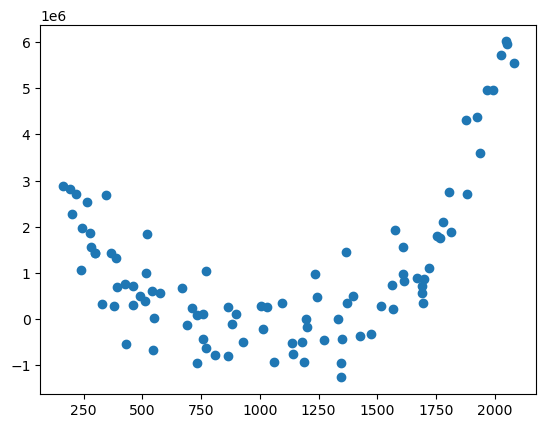

In [51]:
plt.scatter(profit['items_produced'], profit['total_profit'], label="Data")
plt.show()

This is an expected phenomenon called [*economies of scale*](https://en.wikipedia.org/wiki/Economies_of_scale): If you sell a very niche product (few sales) you can usuallyy charge a premium and have good profitability, since there will likely not be sufficient market for many competitors. As your product becomes more mainstream and more players enter the market, the supply pressures lower your profitability. Finally, once you break through to become a large player, as you expand your operations, your fixed costs become more and more diluted by the total number of items sold and your profitability increases again due to your lower operating costs.

In this exercise we are going to try to predict the profitability of the company based on the number of items sold.
Select your Features (X) and your Targets (y) and perform a test-train split.

In [53]:
from sklearn.model_selection import train_test_split

# Feature
X = profit[['items_produced']] 

# Target
y = profit['total_profit'] 

# Perform a train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets 
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (76, 1)
X_test shape: (19, 1)
y_train shape: (76,)
y_test shape: (19,)


# Degree 1

Let's first approach this problem with a simple linear regression

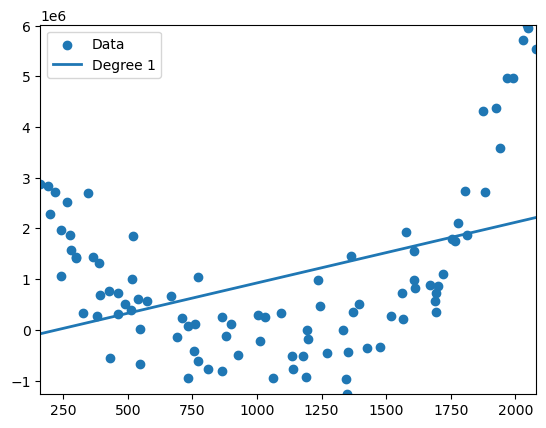

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_poly_train = scaler.fit_transform(X_train)
X_poly_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_poly_train, y_train)

y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

plt.scatter(X, y, label="Data")
X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
y_plot = model.predict(scaler.transform(X_plot))
plt.plot(X_plot, y_plot, label="Degree 1", linewidth=2)
plt.xlim(X['items_produced'].min(), X['items_produced'].max())
plt.ylim(y.min(), y.max())
plt.legend()
plt.show()

We can easily see this is not a good model. It completely misses the niche side of the market and it does not approximate well  the profitability of the large players. This is a weak model with little generalization power.
This model exhibits *high bias*: the data DOES NOT fit well with the training data. It is however a nodel with *low variance*: the profit predicted  swings in expected ways with the sold units.
This is typical in cases of *Underfitting*.

# Degree 2

We are going to introdduce a common regression technique called *polynomial regression*. When you have a single feature $X$ and you apply a linear regression you are finding the optimal coefficientf for the formula

$$ y = \beta_0 + \beta_1 X $$

We are going to create new features by considering powers of the base feature $X$, so a *quadratic* regression would produce the optimal coefficients for the formula

$$y = \beta_0 + \beta_1 X + \beta_2 X^2$$

and a *cubic* regression would produce the optimal coefficients for the formula

$$y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3$$

and so on.

This way, with a single feature *X* you can produce multiple features $X^2$, $X^3$, etc to apply a higher dimensional Linear Regression. We create these extra features $X^2$, $X^3$ using a sklearn preprocessing tool called *PolynomialFeatures*

In [225]:
#polynomial features of degree 1 gives us a constant term plus the linear term 
from sklearn.preprocessing import PolynomialFeatures

X_example = [[1],[2],[3],[5]]
poly_features = PolynomialFeatures(degree=1)
poly_features.fit_transform(X_example)

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

In [226]:
#polynomial features of degree 2 gives us a constant term plus the linear term, plus a quadratic term 
X_example = [[1],[2],[3],[5]]
poly_features = PolynomialFeatures(degree=2)
poly_features.fit_transform(X_example)

array([[ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.]])

In [227]:
#polynomial features of degree 2 gives us a constant term plus the linear term, plus a cubic term 
X_example = [[1],[2],[3],[5]]
poly_features = PolynomialFeatures(degree=3)
poly_features.fit_transform(X_example)

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

And so on. So, if we want to use a quadratic approximation to this problem we run the following code

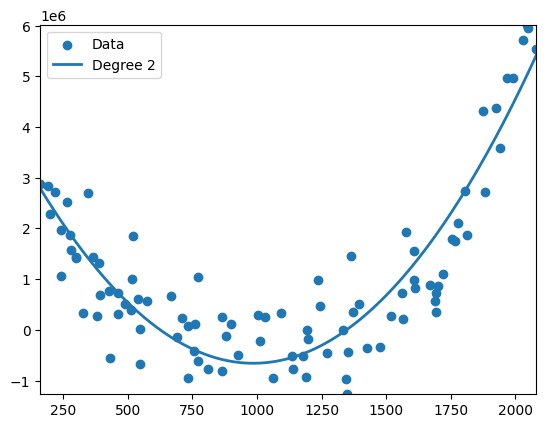

In [228]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

scaler = StandardScaler()
poly_features = PolynomialFeatures(degree=2)  # here is where the 2 comes in
X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
X_poly_test = scaler.transform(poly_features.transform(X_test))

model = LinearRegression()
model.fit(X_poly_train, y_train)

y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

plt.scatter(X, y, label="Data")
X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
y_plot = model.predict(scaler.transform(poly_features.transform(X_plot)))
plt.plot(X_plot, y_plot, label="Degree 2", linewidth=2)
plt.xlim(X['items_produced'].min(), X['items_produced'].max())
plt.ylim(y.min(), y.max())
plt.legend()
plt.show()

You can see the fit obviously looks much better just by visual inspection. Let's keep it going...

# Challenge 2 -Degree 4

Replicate the exercise above but now for degree 4. Is the fit improving?

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error

In [59]:
# Assuming X_train, X_test, y_train, and y_test are already defined from the train-test split

# Set up the scaler and polynomial features transformer for degree 4
scaler = StandardScaler()
poly_features = PolynomialFeatures(degree=4)

In [61]:
# Transform the training and test data
X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
X_poly_test = scaler.transform(poly_features.transform(X_test))

In [63]:
# Train a linear regression model on the polynomial features
model = LinearRegression()
model.fit(X_poly_train, y_train)

LinearRegression()

In [65]:
# Make predictions on the training and test data
y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)

In [67]:
# Calculate mean squared errors for training and test sets
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

In [69]:
# Print the train and test errors
print("Train error (Degree 4):", train_error)
print("Test error (Degree 4):", test_error)

Train error (Degree 4): 382344074347.8567
Test error (Degree 4): 281263489073.59296


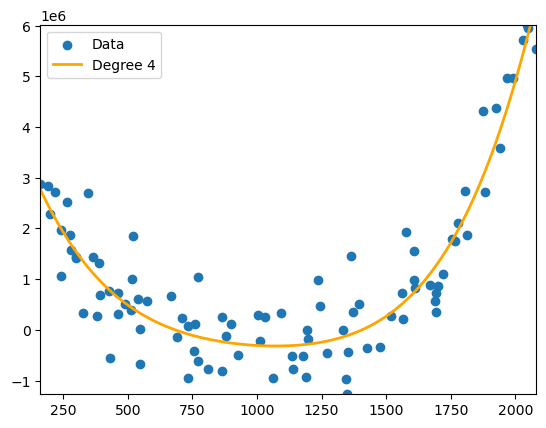

In [71]:
# Plot the data and the polynomial regression curve
plt.scatter(X, y, label="Data")
X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
y_plot = model.predict(scaler.transform(poly_features.transform(X_plot)))
plt.plot(X_plot, y_plot, label="Degree 4", linewidth=2, color="orange")
plt.xlim(X['items_produced'].min(), X['items_produced'].max())
plt.ylim(y.min(), y.max())
plt.legend()
plt.show()

It seems like we keep increasing the fit. The model has more variance, but it also loses more bias in a way that seems like a good tradeoff!

# Challenge 3 -High degrees

so... should we keep this going forever?
Replicate the exercise above but now for degrees 12, 16, 20.... Is the fit improving? Why?

(Bonus question for you to consider: why am I only asking for even degrees?)

In [73]:
# Define degrees to test
degrees = [12, 16, 20]

# Set up lists to store train and test errors for each degree
train_errors = []
test_errors = []

Degree 12:
Train error: 361532653456.9347
Test error: 278131711542.6899
------------------------------


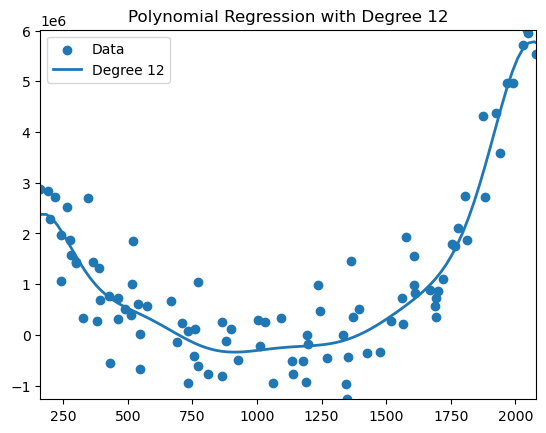

Degree 16:
Train error: 344261291723.4373
Test error: 279209572383.85364
------------------------------


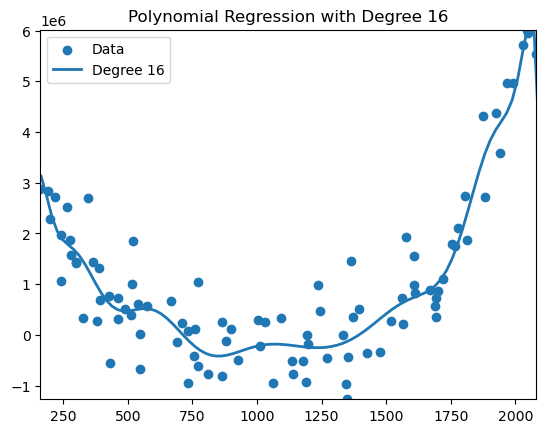

Degree 20:
Train error: 334577550927.5824
Test error: 335031580058.1082
------------------------------


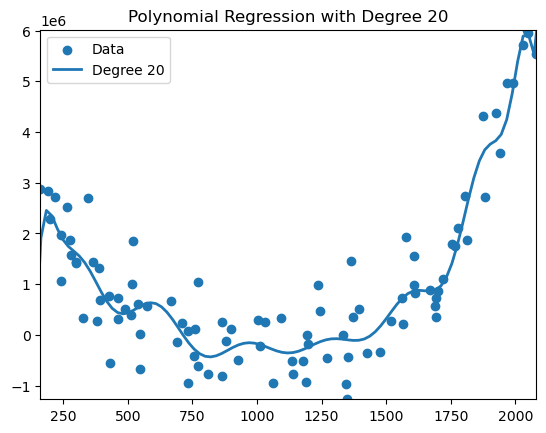

In [75]:
# Loop through each degree
for degree in degrees:
    # Set up the scaler and polynomial features transformer for the current degree
    poly_features = PolynomialFeatures(degree=degree)
    X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
    X_poly_test = scaler.transform(poly_features.transform(X_test))

    # Train a linear regression model on the polynomial features
    model = LinearRegression()
    model.fit(X_poly_train, y_train)

    # Make predictions on the training and test data
    y_train_pred = model.predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)

    # Calculate mean squared errors for training and test sets
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Print the train and test errors
    print(f"Degree {degree}:")
    print("Train error:", train_error)
    print("Test error:", test_error)
    print("-" * 30)

    # Plot the data and the polynomial regression curve for this degree
    plt.figure()
    plt.scatter(X, y, label="Data")
    X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
    y_plot = model.predict(scaler.transform(poly_features.transform(X_plot)))
    plt.plot(X_plot, y_plot, label=f"Degree {degree}", linewidth=2)
    plt.xlim(X['items_produced'].min(), X['items_produced'].max())
    plt.ylim(y.min(), y.max())
    plt.legend()
    plt.title(f"Polynomial Regression with Degree {degree}")
    plt.show()

It looks like the more powerufl models are starting to behave in erratic ways, trying to fit too closely to the training data.
They are getting *lower bias*: the data DOES fit better with the training data...
... but the cost of that is *higher variance*: the models becomes swingy and it seems that it's not reflecting real patterns in the data.

# Challenge 4 -Visualizing errors 

Let's see what happens to the errors.
Run the code above in a loop and collect the *train_error* and *test_error* for each degree. Then plot them all.

In [79]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
degrees = [1, 2, 4, 12, 16, 20]
train_errors = []
test_errors = []

for degree in degrees:
    # Initialize polynomial features transformer and scaler
    poly_features = PolynomialFeatures(degree=degree)
    scaler = StandardScaler()
    
    # Transform and scale the data
    X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
    X_poly_test = scaler.transform(poly_features.transform(X_test))

    # Train a linear regression model on the polynomial features
    model = LinearRegression()
    model.fit(X_poly_train, y_train)

    # Make predictions on the training and test data
    y_train_pred = model.predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)

    # Calculate mean squared errors for training and test sets
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)

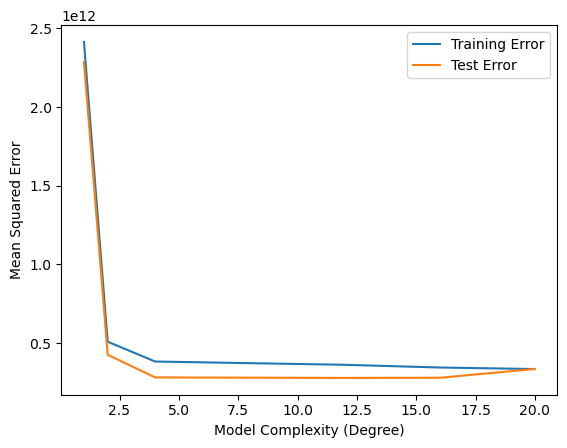

In [83]:
plt.plot(degrees, train_errors, label="Training Error")
plt.plot(degrees, test_errors, label="Test Error")
plt.xlabel("Model Complexity (Degree)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

You see that the training error keeps going down. That is expected: higher order models are more powerful but they start having enough power to fit the noise in the training data. Because of this you see the testing error going up at some point: your model believes natural variation in the training data is part of the fundamental mechanist you are trying to learn and will not be able to generalize. It becomes *overfit*.

# Optional Challenge - Regularization

Regularization is a way of controlling overfitting by imposing a price on the variance of the model. 
Re-run the high dimentionality *degree 20* case above but run a Lasso regression rather than a LinearRegression, with a significant penalty for runaway coefficients.

Hint: where you have 
`model = LinearRegression()`
use instead
`model = Lasso(alpha=100)`

In [85]:
from sklearn.linear_model import Lasso

X = profit[['items_produced']]
y = profit['total_profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
# Define degree for high-dimensional polynomial features
degree = 20

In [89]:
# Set up polynomial features transformer and scaler for degree 20
poly_features = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

In [91]:
# Transform and scale the data
X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
X_poly_test = scaler.transform(poly_features.transform(X_test))

In [93]:
# Train a Lasso regression model with a strong penalty (alpha=100)
model = Lasso(alpha=100, max_iter=10000)  # max_iter increased for convergence
model.fit(X_poly_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.494e+11, tolerance: 2.199e+10
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=100, max_iter=10000)

In [95]:
# Make predictions on the training and test data
y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)

In [97]:
# Calculate mean squared errors for training and test sets
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

# Print the train and test errors
print("Train error with Lasso (Degree 20, alpha=100):", train_error)
print("Test error with Lasso (Degree 20, alpha=100):", test_error)

Train error with Lasso (Degree 20, alpha=100): 365305862516.30646
Test error with Lasso (Degree 20, alpha=100): 284192187236.8883


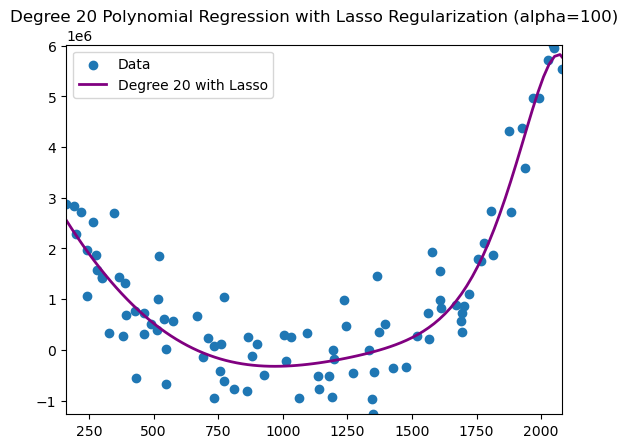

In [99]:
# Plot the data and the polynomial regression curve for degree 20 with Lasso regularization
plt.scatter(X, y, label="Data")
X_plot = pd.DataFrame(np.linspace(100, 2200, 100).reshape(-1, 1), columns=['items_produced'])
y_plot = model.predict(scaler.transform(poly_features.transform(X_plot)))
plt.plot(X_plot, y_plot, label="Degree 20 with Lasso", linewidth=2, color="purple")
plt.xlim(X['items_produced'].min(), X['items_produced'].max())
plt.ylim(y.min(), y.max())
plt.legend()
plt.title("Degree 20 Polynomial Regression with Lasso Regularization (alpha=100)")
plt.show()

And now redo the test_error vs train_error plotting above, but using a Lasso regession rather than a linear regression.

What happens to the bias-variance tradeoff in this case?

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.422e+12, tolerance: 2.199e+10
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.549e+12, tolerance: 2.199e+10
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e+12, toler

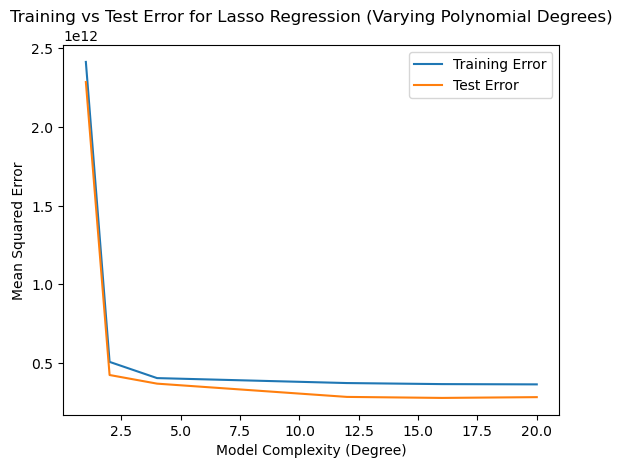

In [101]:
degrees = [1, 2, 4, 12, 16, 20]
train_errors = []
test_errors = []

for degree in degrees:
    # Set up polynomial features transformer and scaler for the current degree
    poly_features = PolynomialFeatures(degree=degree)
    scaler = StandardScaler()
    
    # Transform and scale the data
    X_poly_train = scaler.fit_transform(poly_features.fit_transform(X_train))
    X_poly_test = scaler.transform(poly_features.transform(X_test))

    # Train a Lasso regression model with a penalty (alpha=100)
    model = Lasso(alpha=100, max_iter=10000)  # max_iter increased for convergence
    model.fit(X_poly_train, y_train)

    # Make predictions on the training and test data
    y_train_pred = model.predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)

    # Calculate mean squared errors for training and test sets
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)

plt.plot(degrees, train_errors, label="Training Error")
plt.plot(degrees, test_errors, label="Test Error")
plt.xlabel("Model Complexity (Degree)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("Training vs Test Error for Lasso Regression (Varying Polynomial Degrees)")
plt.show()